In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../../..')

In [2]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import scipy.stats as scist

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

from IPython.display import HTML
from IPython.core.display import Markdown as md

from tqdm.auto import tqdm

import yfinance as yf

from analysis.fincalcs import log_returns
from sklearn.model_selection import train_test_split
from analysis.options.pricing.phat import PHAT, CarbenHybrid
from analysis.options.pricing.learn.normnet import mon_mean, mon_std, gnll_loss, DN
from analysis.options.pricing.learn.utils import nnelu, asymmactiv, Dataset
from analysis.options.pricing.learn.phatnet import PhatDN
from analysis.options.pricing.learn.dists import Phat4TF

# Fitting PHAT with a Neural Network #

The Peak-Over-Threshold (POT) procedure outlined above can be effective in estimating an appropriate tail index; after all, simply acknowledging a fat tail in the data is a transformational step in understanding and interpreting our data. Furthermore, this acknowledgement must come with further acceptance that, given the fat tail, it is highly unlikely that the extreme values seen historically reflect the exact nature of the tail. Tail events are simply too rare and too large for us to be comfortable that historical data is all-encompassing (in most instances).

STILL, POT is of course a highly manual process. A more computative procedure would allow for automation and also help confirm the guess work of mere humans.

Carreau and Bengio (2006) and (2009) continue to be a source of inspiration as they showed how their hybrid Pareto scheme could fit a conditional distribution using a simple feed forward neural network.

We will apply their work (and others) to the fit of the PHAT distribution via a neural network. First, we have a primer on fitting random variables in tensorflow/keras.

## Fitting a Standard Normal ##

A conditional density model is estimated by providing one or many independent variables, $X$, and a dependent variable, $Y$. In our case, we are looking to fit the density function of an independent variable. In Tensorflow/Keras, we must provide both $X$ and $Y$ input tensors, so to accomplish this we can simply set $X=0$ for every sample of $Y$:

$
X_i = 0; i = 1 ... n
\\Y_i = \text{independent variable}
$

In this example, we will generate 100,000 samples from a standard Normal distribution and attempt to fit the Probability Density Function (PDF). We will use the utility class `Dataset` in the `phattails` package to split the data for training purposes.

In [3]:
n = 100000
x_data = np.zeros(n)
y_data = scist.norm(0, 1).rvs(size=n)
data = Dataset(x_data, y_data)

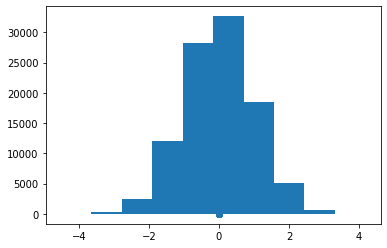

In [4]:
plt.scatter(x_data, y_data)
plt.hist(y_data)
plt.show()

We have built a very simple neural network of `DN` class that takes in both $X$ and $Y$ variables, passes them through 3 hidden layers (all utilizing the `relu` activation), and in turn passing values onto two separate intermediate layers for $\mu$ and $\sigma$, the parameters of the Normal distribution. $\sigma$ is then passed through a customized `nnelu` activation, which is simply the `relu` with a restriciton to only positive numbers.

The loss function is the negative log-likelihood, NLL, which is simply the probability density function based on the estimated paramters and the $Y_i$ value pulled from the sample.

In [5]:
tf.keras.backend.set_floatx('float64')

keras.utils.get_custom_objects().update({
    'nnelu': layers.Activation(nnelu),
    'mean': mon_mean,
    'std': mon_std
})

In [6]:
dn = DN(neurons=200)
dn.compile(
    loss=gnll_loss, 
    optimizer=keras.optimizers.Adam(),
    metrics=['mean', 'std']
)
dn.build_graph().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 200)          400         input_1[0][0]                    
__________________________________________________________________________________________________
h2 (Dense)                      (None, 100)          20100       h1[0][0]                         
__________________________________________________________________________________________________
h3 (Dense)                      (None, 12)           1212        h2[0][0]                         
______________________________________________________________________________________________

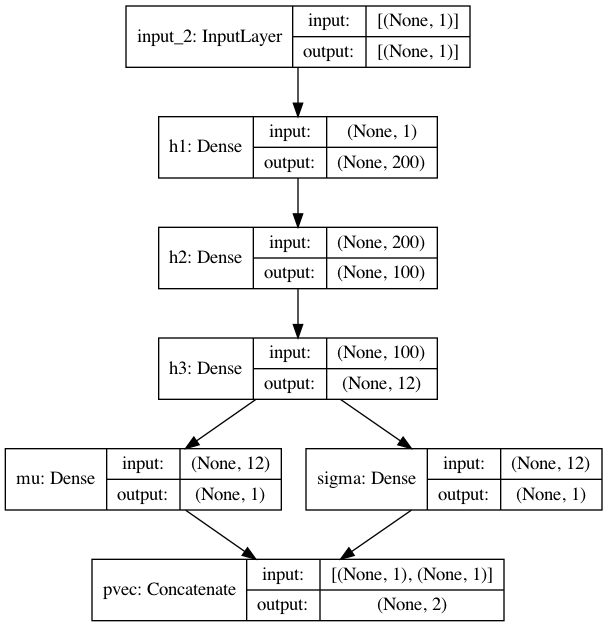

In [7]:
tf.keras.utils.plot_model(
    dn.build_graph(),
    to_file='dn_example.png', dpi=96,
    show_shapes=True, show_layer_names=True,
    expand_nested=False
)

In [8]:
stop_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = dn.fit(
    data.train.x, data.train.y, epochs=20, 
    validation_data=data.test, 
    callbacks=[stop_loss], batch_size=32, verbose=1
)

Epoch 1/20
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4195 - mean: 0.0053 - std: 1.0002 - val_loss: 1.4052 - val_mean: 0.0114 - val_std: 1.0054
Epoch 2/20
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4195 - mean: 0.0064 - std: 1.0009 - val_loss: 1.4050 - val_mean: 0.0030 - val_std: 1.0008
Epoch 3/20
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4195 - mean: 0.0057 - std: 1.0004 - val_loss: 1.4049 - val_mean: 0.0119 - val_std: 0.9972
Epoch 4/20
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4195 - mean: 0.0059 - std: 1.0005 - val_loss: 1.4051 - val_mean: 0.0048 - val_std: 1.0053
Epoch 5/20
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4195 - mean: 0.0048 - std: 1.0008 - val_loss: 1.4051 - val_mean: 0.0197 - val_std: 1.0015
Epoch 6/20
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4195 - mean: 0.0075 - std: 1.0011 - val_loss: 1.4048 - val_mean: 0.0090 - val_std:

The model minimized the loss almost immediately, resulting in the parameters below. They are shown next to return values from `scipy`'s fit function utilizing the Maximum Likelihood Estimate (MLE):

In [9]:
mean, std = dn.predict(np.zeros(1))[0]
m, s = scist.norm.fit(y_data)

df = pd.DataFrame([[mean, std], [m, s]], index=['ANN', 'MLE'], columns=['mean', 'std'])
df.style.format({'mean': '{:.4f}', 'std': '{:.4f}'})

,mean,std
ANN,0.0260,0.9996
MLE,0.0058,0.9987


In [10]:
text = "The standard deviation is already quite accurate and"
text += f" the NN mean of {mean:.4f} doesn't seem like a large deviation"
text += ' but with continuous daily returns'
text += f' that translates to a {np.exp(mean)**252-1:.2%} CAGR.'
text += ' Thankfully, we can improve it.'

md(text)

The standard deviation is already quite accurate and the NN mean of 0.0260 doesn't seem like a large deviation but with continuous daily returns that translates to a 69660.11% CAGR. Thankfully, we can improve it.

Here, we see the negative log-likelihood for NN estimated parameters:

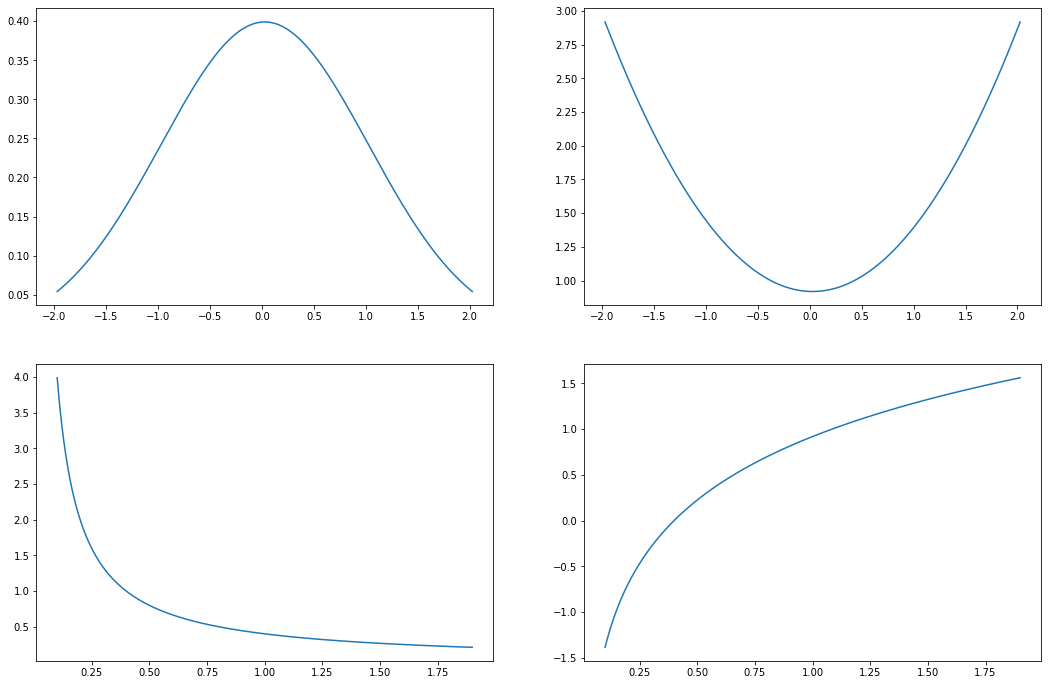

In [11]:
dist = scist.norm(mean, std)

y = np.linspace(mean-std*2,mean+std*2,1000)
siglin = np.linspace(.1, 1.9, 1000)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(y, dist.pdf(y), label='trained')
ax2.plot(y, -np.log(dist.pdf(y)), label='trained')
ax3.plot(siglin, scist.norm.pdf(mean, mean, siglin), label='trained')
ax4.plot(siglin, -np.log(scist.norm.pdf(mean, mean, siglin)), label='trained')

plt.show()

Below we see how the loss changed across the epochs:

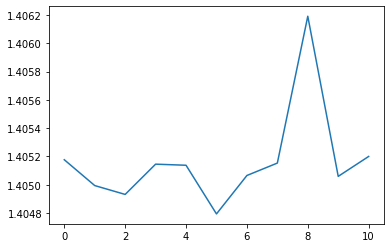

In [12]:
plt.plot(history.history['val_loss'])
plt.show()

And below we can see how $\mu$ changed as the loss was reduced.

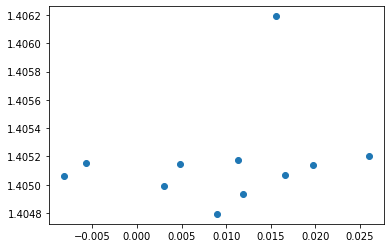

In [13]:
plt.scatter(history.history['val_mean'], history.history['val_loss'])
plt.show()

Finally, we show the same relationship as an animation:

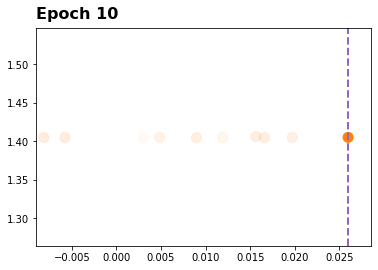

In [14]:
anime = dn.loss_progress(history=history)
HTML(anime.to_html5_video())

# anime.save('/Users/spindicate/Documents/docs/covid19/charts/Cases v Tests in {} US States - {} Sort {}DMA{}.mp4'.format(df_anime.region_name.unique().shape[0], sort_by.capitalize(), casestudy.count_dma, ' - TWEET' if w==8 else ''))

In [15]:
lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=250,
    decay_rate=0.9
)
dn = DN(neurons=200)
dn.compile(
    loss=gnll_loss, 
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=['mean', 'std']
)
stop_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = dn.fit(
    data.train.x, data.train.y, epochs=100, 
    validation_data=data.test, 
    callbacks=[stop_loss], batch_size=32, verbose=1
)

Epoch 1/100
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4201 - mean: 0.0059 - std: 1.0014 - val_loss: 1.4050 - val_mean: -7.7747e-04 - val_std: 1.0004
Epoch 2/100
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4196 - mean: 0.0051 - std: 1.0005 - val_loss: 1.4053 - val_mean: 0.0190 - val_std: 1.0065
Epoch 3/100
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4195 - mean: 0.0049 - std: 1.0000 - val_loss: 1.4054 - val_mean: 0.0160 - val_std: 1.0088
Epoch 4/100
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4194 - mean: 0.0073 - std: 1.0020 - val_loss: 1.4050 - val_mean: 0.0088 - val_std: 0.9993
Epoch 5/100
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4194 - mean: 0.0074 - std: 1.0012 - val_loss: 1.4050 - val_mean: 0.0064 - val_std: 1.0000
Epoch 6/100
2532/2532 [==============================] - 3s 1ms/step - loss: 1.4194 - mean: 0.0058 - std: 1.0001 - val_loss: 1.4050 - val_mean: 0.0061

In [16]:
mean, std = dn.predict(np.zeros(1))[0]
m, s = scist.norm.fit(y_data)

df = pd.DataFrame([[mean, std], [m, s]], index=['ANN', 'MLE'], columns=['mean', 'std'])
df.style.format({'mean': '{:.5f}', 'std': '{:.4f}'})

,mean,std
ANN,0.00625,1.0003
MLE,0.00577,0.9987


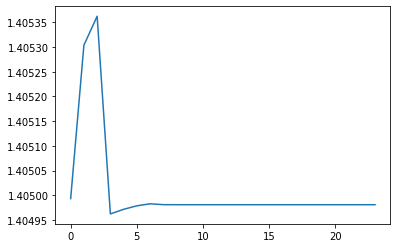

In [17]:
plt.plot(history.history['val_loss'])
plt.show()

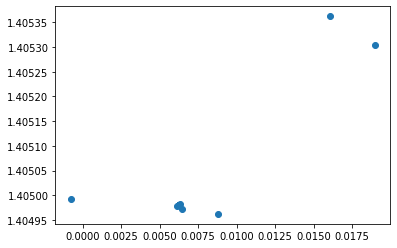

In [18]:
plt.scatter(history.history['val_mean'], history.history['val_loss'])
plt.show()

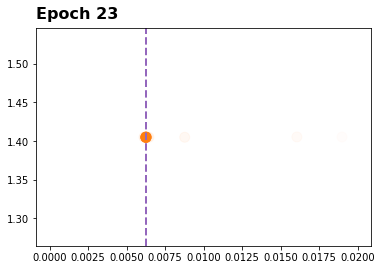

In [19]:
anime = dn.loss_progress(history=history)
HTML(anime.to_html5_video())


## Fitting S&P 500 Daily Log Returns ##

We will repeat the same process now for S&P 500 daily returns.

### Fit to Normal ###

[*********************100%***********************]  1 of 1 completed


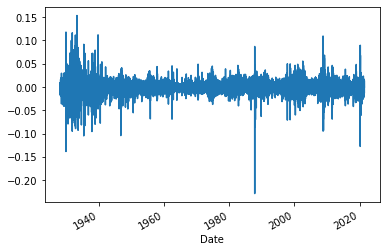

In [20]:
sp = yf.download('^GSPC')
logrets = log_returns(sp.Close)
logrets.plot()
plt.show()

In [21]:
data = Dataset(np.zeros(logrets.size), logrets.values)

In [22]:
dn = DN()
lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=100,
    decay_rate=0.9
)
dn.compile(
    loss=gnll_loss, 
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=['mean', 'std']
)
stop_loss = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, 
    patience=20, verbose=1, mode='auto'
)
history = dn.fit(
    data.train.x, data.train.y, epochs=800, 
    validation_data=data.test, 
    callbacks=[stop_loss], batch_size=32, verbose=1
)

Epoch 1/800
595/595 [==============================] - 1s 1ms/step - loss: -2.7380 - mean: 3.1797e-04 - std: 0.0305 - val_loss: -2.9151 - val_mean: 0.0034 - val_std: 0.0118
Epoch 2/800
595/595 [==============================] - 1s 1ms/step - loss: -2.9330 - mean: 2.8060e-04 - std: 0.0129 - val_loss: -2.8667 - val_mean: 0.0054 - val_std: 0.0150
Epoch 3/800
595/595 [==============================] - 1s 1ms/step - loss: -2.9692 - mean: 2.7547e-04 - std: 0.0125 - val_loss: -2.9536 - val_mean: 7.1424e-04 - val_std: 0.0119
Epoch 4/800
595/595 [==============================] - 1s 1ms/step - loss: -2.9914 - mean: 2.8333e-04 - std: 0.0121 - val_loss: -2.9414 - val_mean: 0.0024 - val_std: 0.0126
Epoch 5/800
595/595 [==============================] - 1s 1ms/step - loss: -2.9987 - mean: 2.7373e-04 - std: 0.0121 - val_loss: -2.9518 - val_mean: 0.0013 - val_std: 0.0122
Epoch 6/800
595/595 [==============================] - 1s 1ms/step - loss: -3.0059 - mean: 2.8938e-04 - std: 0.0121 - val_loss: -2.

In [23]:
mean, std = dn.predict(np.zeros(1))[0]
m, s = scist.norm.fit(logrets)

df = pd.DataFrame([[mean, std], [m, s]], index=['ANN', 'MLE'], columns=['mean', 'std'])
df.style.format({'mean': '{:.5f}', 'std': '{:.4f}'})

,mean,std
ANN,0.00028,0.0119
MLE,0.00023,0.0120


In [24]:
diff = df['mean'].diff().iloc[1]
text = ' To continue with the comparision, the delta between the estimates'
text += f' accounts for just {np.exp(diff)**252-1:.2%} CAGR.'

md(text)

 To continue with the comparision, the delta between the estimates accounts for just -1.16% CAGR.

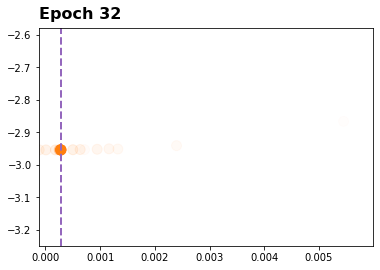

In [25]:
anime = dn.loss_progress(history)
HTML(anime.to_html5_video())